# Network Analysis Project 
#### Building an Recommendation System from Bipartite Networks
---

*Ludek Cizinský (luci@itu.dk)*, *Louis Brandt (locb@itu.dk)*, *Lukas Rasocha (lukr@itu.dk)*, *Mika Senghaas (jsen@itu.dk)*, *Jacob Victor Enggaard Haahr (javh@itu.dk)*

Course Manager: *Michele Coscia*

Deadline: *22nd Decemeber 2021*

Last Modified: *10th November 2021*

## Assignment Description
---
You will have to deliver your project at the end of the course (deadline to be determined). You have to hand in a presentation (in PDF or Power Point format). It is mandatory to include the following information:

- Basic network description of your data (what type of network it is, what does it represent, is it real or synthetically generated, etc). In practice, the result of project phase #1 (finding data).
- Basic network statistics of your data (number of nodes, edges, clustering, degree distribution, etc). In practice, the result of project phase #2 (exploratory data analysis).
- A clear statement of your research question, the result of project phase #3.
- The analysis, results, and interpretation that allow you to answer your research question, the result of project phase #4.

You're free to include this in the order you prefer and to add any additional information you deem necessary, but these are the mandatory components.

The format of the oral is as follows: the students make a joint presentation followed by group questions. Subsequently the students are having individual examination with additional questions while the rest of the group is outside the room. The length of the oral will be 15 minutes X number of group members plus one -- for instance, a group of 6 will have 105 minutes ((6+1)*15). Which means you have 15 minutes of group exam plus 15 minutes of individual exam each.

## Environment Setup
---
This project uses Python libraries that are essential for the performed analysis. Make sure to have the dependencies listed in `requirements.txt` installed locally using the *Python Package Manager* `pip`. If installed, running the next code cell should install all relevant dependencies. Check documentation via the provided links:

- [*NetworkX* Documentation](https://networkx.org/documentation/stable/reference/index.html)

- [*NumPy* Quickstart](https://numpy.org/doc/stable/user/quickstart.html)
- [*Matplotlib* Documentation](https://matplotlib.org/stable/tutorials/introductory/usage.html)
- [*Pandas* Documentation](https://pandas.pydata.org/docs/)

### Libraries

In [ ]:
%%capture
!pip install -r requirements.txt

In [2]:
# network representation and algorithms
import networkx as nx
from networkx.algorithms import bipartite
from pyvis.network import Network
from networkx import linalg as nxla
import powerlaw as pl                                            # powerlaw fits for degree distribution
from IPython.display import display, Image, Markdown             # display images and markdown in jupyter

# general data science libraries
from matplotlib import pyplot as plt                            # basic plotting
import seaborn as sns                                           # advanced plotting
import numpy as np                                              # for representing n-dimensional arrays
import scipy as sp                                              # numerical computation
import pandas as pd                                             # dataframes

# python standard library
from time import time                                           # used for timing execution
from datetime import date, datetime                             # get current data and time
import json                                                     # read/ write json
import re                                                       # regex search 
import os                                                       # os operations
import random                                                   # randomness
from collections import Counter                                 # efficient counting
import contextlib

# custom imports
from cscripts import metrics
from cscripts import plotting
from cscripts import summarise
from cscripts import backboning # michele

### Set global style of plots

Below you can specify global style for all plots or any other setups related to plots visualization.

In [3]:
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})

### Flags

Flags are used to control the run flow of the notebook when executed at once. This is useful, to prevent operations that should only produce a result once, from running multiple times. 

In [5]:
# section flags
LOAD_DATA = True # Loads raw data for initial inspection
TRANSFORM_DATA = False # Transforms raw data into more suitable format (Load data needs to be on as well)
COMPUTE_PROJECTIONS = False
GENERATE_SUMMARY_PROJ = True # Summary related to projections only
DO_BACKBONING = False
GENERATE_SUMMARY_PROJ_BACKB = False # Summary related to projected AND backboned graph
SAVE_FIG = False # Do you want to save all generated figures?

### Constants



In [6]:
PATH_TO = {}
PATH_TO['data'] = {}
PATH_TO['data']['raw'] = 'data/raw'
PATH_TO['data']['transformed'] = 'data/transformed'
PATH_TO['data']['projections'] = 'data/projections'
PATH_TO['data']['backboning'] = 'data/backboning'
PATH_TO['data']['backboned_thresholded'] = 'data/backboned_thresholded'
PATH_TO['data']['figures'] = 'data/figures'
PATH_TO['data']['summaries'] = 'data/graph_summaries'
PATH_TO['data']['metadata'] = 'data/metadata'

### Folder Structure

Create relevant folders to read from and write to, if not yet existent.

In [7]:
# iterate over path_to dict
for path in PATH_TO['data'].values():
    os.makedirs(path) if not os.path.exists(path) else print('Already exists.')

Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.
Already exists.


## #01 Loading and Inspecting Raw Data
---

In [7]:
if LOAD_DATA:
    data = pd.read_csv(f"{PATH_TO['data']['raw']}/data.txt", delimiter=":", names=["user_id", "repo_id"])
    repos = pd.read_csv(f"{PATH_TO['data']['raw']}/repos.txt", delimiter=":", names=["repo_id", "meta_info"])
    lang = pd.read_csv(f"{PATH_TO['data']['raw']}/lang.txt", delimiter=":", names=["repo_id", "meta_info"])

### `data.txt`

This is the main dataset.  Each line is of the format `<user_id>`:`<repo_id>`
which represents a user watching a repository.  There are 440,237 records
in this file, each a single `user_id` and a single `repository_id` seperated by a colon. This file, thus, represents the bipartite graph of users following repositories as an edge list. The data looks like this:

In [8]:
print(f"Size of data.txt: {data.shape}")
print(f"Number of Unique Users: {len(np.unique(data['user_id']))}")
print(f"Number of Unique Repos: {len(np.unique(data['repo_id']))}")

data.head()

Size of data.txt: (440237, 2)
Number of Unique Users: 56519
Number of Unique Repos: 120867


,user_id,repo_id
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5


### `repos.txt`

This file lists out the 120,867 unique repositories using their id (`repo_id`) that are used in the `data.txt`
set, providing the repository name, date it was created and (if applicable)
the repository id that it was forked off of.  The data looks like this:

In [8]:
print(f"Size of repo.txt: {repos.shape}")
print(f"ID's of data.txt and repos.txt match: {sum(np.unique(data['repo_id']) == np.unique(repos['repo_id'])) == 120867}")
print(f"No. of Repos with forking info: {sum(repos['meta_info'].apply(lambda x: len(x.split(','))) == 3)}")

repos.head()

Size of repo.txt: (120867, 2)
ID's of data.txt and repos.txt match: True
No. of Repos with forking info: 38954


,repo_id,meta_info
0,1,"richardc/perl-number-compare,2009-02-26"
1,2,"axiomsoftware/axiom-inspector,2009-05-09"
2,3,"rails/open_id_authentication,2008-05-29"
3,4,"brandonkelly/bk.fieldframe.ee_addon,2009-01-31"
4,5,"skinofstars/boxfire,2009-01-31"


### `lang.txt`

The last dataset included is the language breakdown data.  This lists  only contains 73,496 repositories, for which the language data was available. Each line of this file lists the repository id, then a comma delimited list of 
`<lang>`;`<lines>` entries containing each major language found and the number
of lines of code for that language in the project.  The data looks like this:

In [9]:
print(f"Size of repo.txt: {lang.shape}")

lang.head()

Size of repo.txt: (73496, 2)


,repo_id,meta_info
0,8213,"JavaScript;802,Ruby;395056"
1,24640,"Shell;173,Java;2580,Groovy;26623,JavaScript;13..."
2,41067,Ruby;52570
3,82135,Ruby;175049
4,16427,Perl;15008


## #02 Transforming Data
---

The goal of this section is to get the following two files:
- data.txt = edge list containing our bipartite network
- metadata.json = json file containing metadata about each repository within our bipartite network

###  Adding Class to Nodes in Edge List 

In the edge list `data.txt` the edges connecting a node of type *User* (from now referred to as $U$) to a node of type *Repository* (from now referred to as $R$) cannot be differentiated on each row. (e.g. 1:1 -> we need to denote that one on the left belongs to user and the other 1 to repository) To read in the graph object correctly at a later point, we therefore add correct labeling into that dataframe by adding `u` to user ids and `r` to repo ids.

In [10]:
if TRANSFORM_DATA:
    data["user_id"] = data["user_id"].apply(lambda x: "u" + str(x))
    data["repo_id"] = data["repo_id"].apply(lambda x: "r" + str(x))

### Create Metadata

Here we combine `repos.txt` and `lang.txt` into one json file where keys are `repo ids` and values are corresponding `metadata`. Note that `repos.txt` should have info about all repos in our network, however `lang.txt` has only info about a subset of repos.

In [11]:
if TRANSFORM_DATA:
    # save repo metadata in dictionary
    metadata = {}
    repo_lang_mismatches = [] # Includes IDs of repos present in lang.txt but not in repos.txt

    # save metadata from repos.txt
    for i in range(len(repos)):
        repo_id, meta_info = repos.iloc[i]

        # parse the meta info
        if len(meta_info.split(',')) == 2:
            repo_name, creation_date, forked_from_id = meta_info.split(',') + [None]
        else:
            # you had None here at index 2 as well (not intended?)
            repo_name, creation_date, forked_from_id = meta_info.split(',')

        # save to dict
        metadata[f"r{repo_id}"] = {
            "repo_name": repo_name,
            "creation_date": creation_date,
            "forked_from_id": forked_from_id
        }
    
    # save metadata from lang.txt
    for i in range(len(lang)):
        repo_id, lang_info = lang.iloc[i]
       
        # save it
        if f"r{repo_id}" in metadata.keys():
            metadata[f"r{repo_id}"]["languages"] = [l.split(';') for l in lang_info.split(',')]
        
        # It means that there is a repository in lang.txt which is not present in repos.txt
        else:
            repo_lang_mismatches.append(repo_id)

### Save Transformed Files

For faster access later, the following code cell saves the transformed network data and meta data into the directory `data/transformed`. 

In [12]:
if TRANSFORM_DATA:
    # save edge list
    data.to_csv(f"{PATH_TO['data']['transformed']}/data.txt", header=False, index=False)
    
    # Save mismatches
    with open(f"{PATH_TO['data']['transformed']}/mismatches.csv", "w") as fp:
        fp.write(",".join([str(repoid) for repoid in repo_lang_mismatches]))

    # save metadata as json
    with open(f"{PATH_TO['data']['transformed']}/metadata.json", "w") as fp:
        json.dump(metadata, fp)

## #03 Network Cleaning
---

### Solve problems with mismatches (repos.txt <> lang.txt)

We start by double checking that indeed intersection of set of available repos and set of mismatch repos is empty

In [13]:
# Load mismatches = repos present in lang.txt but not in repos.txt
with open(f"{PATH_TO['data']['transformed']}/mismatches.csv", "r") as fp:
    mismatches = fp.readlines()[0].split(',')

# Load all repos present
repos = pd.read_csv(f"{PATH_TO['data']['raw']}/repos.txt", delimiter=":", names=["repo_id", "meta_info"])

# Double check that indeed intersection of set of available repos and set of mismatch repos is empty
len(set(repos["repo_id"]) & set(mismatches)) == 0

True

According to the description repos in `data.txt` should be all present within `repos.txt`. In other words, difference between these two sets should be an empty set. Let's check this.

In [14]:
# Load data from data.txt
datatxt = pd.read_csv(f"{PATH_TO['data']['raw']}/data.txt", delimiter=":", names=["user_id", "repo_id"])

# Check the above mentioned assumption
len(set(datatxt["repo_id"]) - set(repos["repo_id"])) == 0

True

Given the above two tests, we can safely conclude that mismatched **repos can be ignored.**

### Solve problems nodes whose edges were randomly removed

`Description of the problem:`

I found out one important thing which we need to decide about. It is concerned with the stucture of our data. According to this website, the way the dataset was created was:
- They retrieved all repo watches from their database (each edge then represents one watch in our network). Github was created back in 2008, therefore back then they “only” had around 0.5 million watches in db
- From this set of watches, some of them were held back, i.e., removed from the dataset.
- We were then provided a dataset of watches except from those that were withheld and from dataset called test.txt we know which users were impacted by this transformation. In other words, these users (roughly. 5000) have only a subset of their watches.
- In total, there is around 56k users, and my question is to you what do we do with the 5k users about which we have incomplete information? (The reason why they withheld the watches is that the challenge of the contest was to predict these withheld watches…)

`Proposed solution:`

I think that it is reasonable to keep the affected users within the network and argue that we are working with a network which was adjusted by the approach described above, but most importantly, the above approach was random. In other words, the above approach for example did not focus on users which represent hubs. Another argument would be that this way, we do not lose information which we would have lost by dropping affected users.

## #04 Summarise Pre-Processed Bi-Partite Network
---

After having transformed the raw data in a format that is easily usable to be loaded as a graph object, we load our graph. We are using `networkX` - the standard library in Python for representation, visualisation and computation on graphs. 

In [9]:
# load graph
G = nx.read_edgelist(f"{PATH_TO['data']['transformed']}/data.txt", delimiter=",", comments='#', create_using=nx.Graph)

In [10]:
# load metadata
with open(f"{PATH_TO['data']['transformed']}/metadata.json", "r") as fp:
    metadata = json.load(fp)

# add metadata to graph nodes
for repo_id, vals in metadata.items():
    to_add = {repo_id: vals}
    nx.set_node_attributes(G, to_add, "metadata")

In [11]:
# Show a random node's attributes
G.nodes["r2"]["metadata"]

{'repo_name': 'axiomsoftware/axiom-inspector',
 'creation_date': '2009-05-09',
 'forked_from_id': None,
 'languages': [['JavaScript', '2940890']]}

### Fundamental information

Below, you can find fundamental information about our bi-partite network.

In [12]:
# Store fundamental properties within pandas DF
overview = pd.DataFrame(columns=["name", "is_bipartite", "is_directed", "is_weighted", "selfloops_#", "nodes_#", "edges_#", "density"])

# save important data to dict
G_info = dict()

# fundamental stats
G_info["name"] = "Github contest 2009"
G_info["number_of_users"] = len([node for node in G.nodes() if node[0] == 'u'])
G_info["number_of_repos"] = len([node for node in G.nodes() if node[0] == 'r'])
G_info["is_directed"] = nx.is_directed(G)
G_info["is_weighted"] = nx.is_weighted(G)
G_info["selfloops_#"] = nx.number_of_selfloops(G)
G_info["nodes_#"] = nx.number_of_nodes(G)
G_info["edges_#"] = nx.number_of_edges(G)
G_info["density"] = nx.density(G)
G_info["is_bipartite"] = bool(nx.is_bipartite(G))

# add it do the overview
overview = overview.append(G_info, ignore_index=True)
overview

,name,is_bipartite,is_directed,is_weighted,selfloops_#,nodes_#,edges_#,density,number_of_repos,number_of_users
0,Github contest 2009,True,False,False,0,177386,440237,0.000028,120867.0,56519.0


### Top 10 repositories

Below, we show 10 most popular repositories. Here are the interesting insights:
- Each repository is written in Ruby, it is also the leading language in terms number of lines of code
- The above perhaps corresponds to the fact that the top repository is rails which is a framework for web development for Ruby developers. Here is a relevant [article](https://syndicode.com/blog/why-is-ruby-still-our-choice-in-2020-2/) about Ruby popularity over time.
- In addition, Github is developed using Ruby on Rails, perhaps that is where the popularity comes from. According to [this](https://gitstar-ranking.com/rails) site, Rails ranks 65th as of today.
- Looking at other repositories, we can see that they correspond to web-development, e.g. authlogic or cucumber (platform for testing)
- *(feel free to add more here)*

In [13]:
repos_degree = sorted([(repo, G.degree(repo)) for repo in G.nodes() if repo[0] == 'r'], key=lambda x: x[1], reverse=True)[:10]
repo_info = {
    "id": [repo_tuple[0] for repo_tuple in repos_degree],
    "name": [G.nodes[repo_tuple[0]]["metadata"]["repo_name"] for repo_tuple in repos_degree],
    "degree": [repo_tuple[1] for repo_tuple in repos_degree],
    "technology_stack": [G.nodes[repo_tuple[0]]["metadata"]["languages"] for repo_tuple in repos_degree]
}
top_10_repos = pd.DataFrame(repo_info)
top_10_repos

,id,name,degree,technology_stack
0,r17,rails/rails,3675,"[[JavaScript, 2438], [Ruby, 5423161]]"
1,r302,technoweenie/restful-authentication,1929,"[[Ruby, 140923]]"
2,r654,mislav/will_paginate,1611,"[[Ruby, 90684]]"
3,r76,joshuaclayton/blueprint-css,1565,"[[Ruby, 32998]]"
4,r616,binarylogic/authlogic,1438,"[[Ruby, 236385]]"
5,r58,thoughtbot/paperclip,1362,"[[Ruby, 153462]]"
6,r8,aslakhellesoy/cucumber,1159,"[[C Sharp, 339], [Java, 355], [Ruby, 319537]]"
7,r866,madrobby/scriptaculous,1136,"[[Ruby, 3893], [JavaScript, 40316]]"
8,r84,dchelimsky/rspec,1100,"[[Ruby, 726592]]"
9,r29,technoweenie/attachment_fu,1006,"[[Ruby, 132960]]"


### Most used programming languages

Below, we can see most used programming languages in terms of package development. Here are the notes/thoughts about the below result:
- we should be aware that this metric can be easily skewed by outliers, i.e., you can have one large repository which will contribute a lot

- C, Ruby, C++ as top 3 languages is not a surprise since nowadays C is still one of the most popular programming languages, with regards to Ruby, see the above section
- *(feel free to add more)*

In [14]:
# Save the usage in dict such that: key is repo_name and value is number of lines of code
lang_usage = dict()

# Fill lang_usage
for info in metadata.values():
    if "languages" in info:
        for lang_info in info["languages"]:
            lang_name, n_lines = lang_info
            if lang_name in lang_usage:
                lang_usage[lang_name] += int(n_lines)
            else:
                lang_usage[lang_name] = int(n_lines)

In [15]:
# Prepare the data for plotting
# * First fit it to the pd dataframe
langs = np.array(list(lang_usage.keys())).reshape(-1, 1)
n_lines = np.array(list(lang_usage.values()), dtype=int).reshape(-1, 1)
df_lang_usage = pd.DataFrame(np.concatenate((langs, n_lines), axis=1), columns = ["Lang", "# of lines"])
df_lang_usage['# of lines'] = df_lang_usage['# of lines'].astype('int64')

# * Second sorted by # of lines in descending order (largest first)
sorteddf = df_lang_usage.sort_values(["# of lines"], axis = 0, ascending=False)

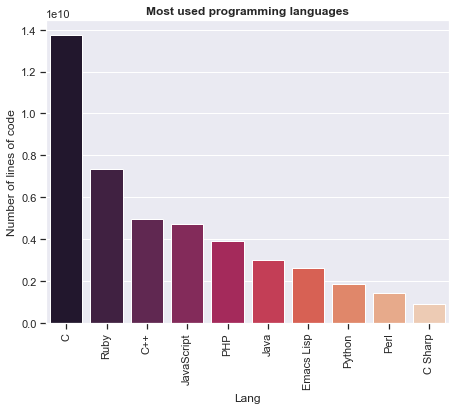

In [16]:
# Setup figure so you can plot inside it
fig = plt.figure(figsize=(7, 6)) # create figure object with a (width,height)
ax = fig.add_axes([0.1,0.2,0.8, 0.7]) # left, bottom, width, height (range 0 to 1)

# Plot the data
sns_plot = sns.barplot(x="Lang", y="# of lines", data=sorteddf[:10], ax=ax, palette="rocket");
ax.tick_params(axis='x', rotation=90);

# Add axis labels
ax.set_ylabel('Number of lines of code');
ax.set_title("Most used programming languages", weight="bold");

# Save plot
if SAVE_FIG:
    plt.savefig(f"{PATH_TO['data']['figures']}/most_used_lang.jpg")

### Degree distribution

*Disclaimer: The code for this section is adapted from [this source](https://www.networkatlas.eu/exercise.htm?c=6&e=4).*

Start with creating a dataframe where one column represents possible degree of nodes, and the other count of nodes which have such degree. In addition, sort it. Do this for both type of nodes.

#### Get df for repos

In [17]:
repos_degree = [G.degree(n) for n in G.nodes() if n[0] == 'r']
dd_repos = Counter(repos_degree)
dd_repos = pd.DataFrame(list(dd_repos.items()), columns = ("k", "count")).sort_values(by = "k")
dd_repos.head()

,k,count
0,1,83030
20,2,16108
15,3,6475
1,4,3494
5,5,2199


#### Get df for users

In [18]:
user_degree = [G.degree(n) for n in G.nodes() if n[0] == 'u']
dd_user = Counter(user_degree)
dd_user = pd.DataFrame(list(dd_user.items()), columns = ("k", "count")).sort_values(by = "k")
dd_user.head()

,k,count
8,1,23400
4,2,10369
22,3,4070
30,4,2750
90,5,1918


#### Visualize degree distribution (in terms of count) for both node types

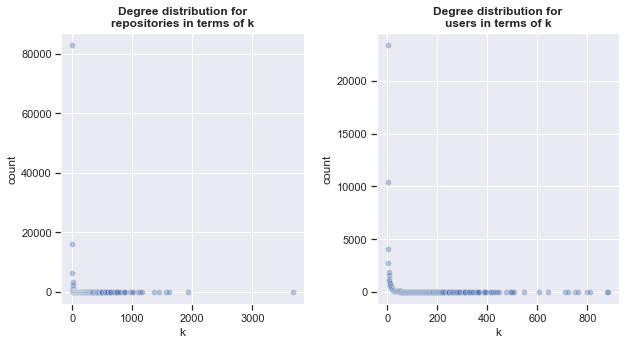

In [19]:
# Define axs and figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=.3)

# Plot the data
for ax, data, which_category in zip(axs, [dd_repos, dd_user], ["repositories", "users"]):
    sns.scatterplot(data=data, x="k", y="count", ax=ax, alpha=0.4)
    ax.set_title(f"Degree distribution for\n{which_category} in terms of k", weight = "bold")

# Save the plot
if SAVE_FIG:
    plt.savefig(f"{PATH_TO['data']['figures']}/dd_bipartite_count.jpg")

#### Visualize degree distribution (in terms of count) on log-log scale for both node types

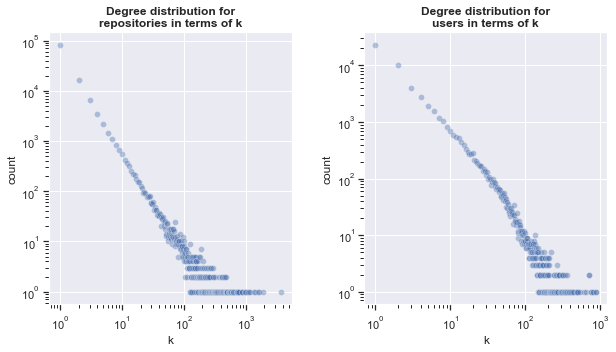

In [20]:
# Define axs and figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=.3)

# Plot the data
for ax, data, which_category in zip(axs, [dd_repos, dd_user], ["repositories", "users"]):
    sns.scatterplot(data=data, x="k", y="count", ax=ax, alpha=0.4)
    ax.set_title(f"Degree distribution for\n{which_category} in terms of k", weight = "bold")
    ax.set_xscale('log')
    ax.set_yscale('log')

# Save the plot
if SAVE_FIG:
    plt.savefig(f"{PATH_TO['data']['figures']}/dd_bipartite_count_loglog.jpg")

#### Get CCDF dataframe for repos

In [21]:
ccdf_repos = dd_repos.sort_values(by = "k", ascending = False)
ccdf_repos["cumsum"] = ccdf_repos["count"].cumsum()
ccdf_repos["ccdf"] = ccdf_repos["cumsum"] / ccdf_repos["count"].sum()
ccdf_repos = ccdf_repos[["k", "ccdf"]].sort_values(by = "k")
ccdf_repos.head()

,k,ccdf
0,1,1.000000
20,2,0.313047
15,3,0.179776
1,4,0.126205
5,5,0.097297


#### Get CCDF dataframe for users

In [22]:
ccdf_users = dd_user.sort_values(by = "k", ascending = False)
ccdf_users["cumsum"] = ccdf_users["count"].cumsum()
ccdf_users["ccdf"] = ccdf_users["cumsum"] / ccdf_users["count"].sum()
ccdf_users = ccdf_users[["k", "ccdf"]].sort_values(by = "k")
ccdf_users.head()

,k,ccdf
8,1,1.000000
4,2,0.585980
22,3,0.402520
30,4,0.330508
90,5,0.281852


#### Visualize CCDF for both node types on a log-log scale

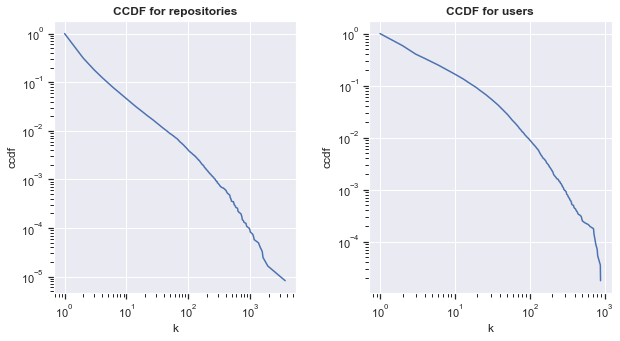

In [23]:
# Define axs and figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=.3)

# Plot the data
for ax, data, which_category in zip(axs, [ccdf_repos, ccdf_users], ["repositories", "users"]):
    sns.lineplot(data=data, x="k", y="ccdf", ax=ax)
    ax.set_title(f"CCDF for {which_category}", weight = "bold")
    ax.set_xscale('log')
    ax.set_yscale('log')

# Save the plot
if SAVE_FIG:
    plt.savefig(f"{PATH_TO['data']['figures']}/dd_bipartite_ccdf_loglog.jpg")

### Power law fit

*Disclaimer: The code for this section is adapted from [this source](https://www.networkatlas.eu/exercise.htm?c=6&e=5).*

*(Need to go over this section and write comments regards to the intepretation)*

#### Compute power law fit for repositories

In [30]:
results = pl.Fit(ccdf_repos["ccdf"])
k_min = ccdf_repos[ccdf_repos["ccdf"] == results.power_law.xmin]["k"]
ccdf_repos["fit"] = (10 ** results.power_law.Kappa) * (ccdf_repos["k"] ** -results.power_law.alpha)
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

Calculating best minimal value for power law fit
Powerlaw CCDF Fit: 10.1134 x ^ -2.0242 (k_min = 68)


#### Compute power law fit for users

In [31]:
results = pl.Fit(ccdf_users["ccdf"])
k_min = ccdf_users[ccdf_users["ccdf"] == results.power_law.xmin]["k"]
ccdf_users["fit"] = (10 ** results.power_law.Kappa) * (ccdf_users["k"] ** -results.power_law.alpha)
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

Calculating best minimal value for power law fit
Powerlaw CCDF Fit: 10.7385 x ^ -1.6929 (k_min = 133)


#### Visualize the fit for both node types

The conclusion from the both plots is that there is now way that either of them follows power law.

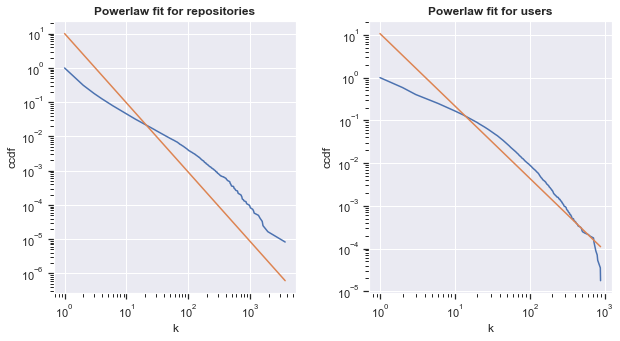

In [32]:
# Define axs and figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=.3)

# Plot the data
for ax, data, which_category in zip(axs, [ccdf_repos, ccdf_users], ["repositories", "users"]):
    sns.lineplot(data=data, x="k", y="ccdf", ax=ax)
    sns.lineplot(data=data, x="k", y="fit", ax=ax)
    ax.set_title(f"Powerlaw fit for {which_category}", weight = "bold")
    ax.set_xscale('log')
    ax.set_yscale('log')

# Save the plot
if SAVE_FIG:
    plt.savefig(f"{PATH_TO['data']['figures']}/power_law_fit_bipartite.jpg")

## #05 Projections
---

In this section, we focus on computing projections of our bipartite network onto repository nodes. The reason why we decided to choose repository nodes is that it makes more sense in the context of our problem, i.e., predicting relevant repositories to follow for the given user. In other words, in the projected network, two nodes will be connected with an edge if they have common neighbors, in this case github users. We use several projections method where each method puts different weight $w$ to given edge.

### Prepare projection methods

Within this section, we focus on implementing selected projection methods from the book. In addition, below, you can also find a short description of each method.

#### Get set of users and repos in ascending order

In [24]:
repos = [node for node in G.nodes() if node[0] == 'r']
users = [node for node in G.nodes() if node[0] == 'u']

#### Define weight functions which do not require vectorization

*(Here, we need to add description of the below methods)*

In [9]:
def simple_weight(G, u, v):
    n_u, n_v = set(G[u]), set(G[v])
    # len of set of intersection
    return len(n_u & n_v) 

def jaccard(G, u, v):
    n_u, n_v = set(G[u]), set(G[v])
    # normalise len of set of intersection by union
    return len(n_u & n_v) / len(n_u | n_v)

def hyperbolic(G, u, v):
    common = set(G[u]) & set(G[v])
    return sum([1/(len(set(G[node])) - 1) for node in common])
    
def probs(G, u, v):  
    common = set(G[u]) & set(G[v])
    return sum([1/(len(set(G[node]))*len(set(G[u]))) for node in common])

def heats(G, u, v):  
    common = set(G[u]) & set(G[v])
    return sum([1/(len(set(G[node]))*len(set(G[v]))) for node in common])

def hybrid(G, u, v):  
    common = set(G[u]) & set(G[v])
    return sum([1/(len(set(G[node]))*len(set(G[u]))*len(set(G[v]))) for node in common])

#### Define weight functions which require vectorization

*(Here, we need to add description of the below methods)*

In [10]:
class VectorisedProjection:
    def __init__(self, G, repos, users):
        self.metric = None
        self.adj = nx.algorithms.bipartite.matrix.biadjacency_matrix(G, repos, users)
        self.repo_map = {repos[i]: i for i in range(len(repos))}

    def project(self, G, u, v):
        
        v_u = np.ravel(self.adj.getrow(0).todense().sum(axis=0))
        v_v = np.ravel(self.adj.getrow(1).todense().sum(axis=0))
        
        if self.metric == 'simple_weight':
            return np.sum((v_u + v_v) == 2)

        elif self.metric == 'euclidean':
            return sp.spatial.distance.euclidean(v_u, v_v)  

        elif self.metric == 'normalised_euclidean':
            return 1 / (np.sqrt(np.sum(np.power((v_u - v_v),2))) + 1)

        elif self.metric == 'pearson':
            return sp.stats.stats.pearsonr(v_u, v_v)[0] + 1

        elif self.metric == 'cosine':
            return 1 - sp.spatial.distance.cosine(v_u, v_v)

        else:
            print("Please specify one of the following metrics: ['simple_weight', 'euclidean', 'normalised_euclidean', 'pearson', 'cosine'].")

### Test the implemented projection methods

The purpose of the below test is to just show that the implemented methods run without error.

In [11]:
# Define functions and their names to be tested
weight_functions = [simple_weight, jaccard, VectorisedProjection, hyperbolic, probs, heats]
func_names = ["Simple weight", "Jaccard", "Vectorised projection", "Hyperbolic", "Probs", "Heats"]

# Select random nodes from our bipartite network for which we want to do the test
u = 'r6'
v = 'r3'

# Run the test
for f, name in zip(weight_functions, func_names):
    if f == VectorisedProjection:
        f = VectorisedProjection(G, repos, users)
        for metric in ['simple_weight', 'euclidean', 'normalised_euclidean', 'pearson', 'cosine']:
            f.metric = metric
            print(f"{name} ({metric}): {f.project(G, u, v)}")
    else: 
        print(f"{name}: {f(G, u, v)}")

NameError: name 'G' is not defined

### Test the performance of the implemented methods

The goal of this section is to test performance of implemented methods. Or in other words, we want to figure out which methods are able to finish within a realistic timeframe.

#### Default benchmark

We tried to use `simple weight` projection method on our network, and it finished within `10 min`. Below, we look at the average time which it takes to compute weight for one edge.

In [ ]:
# Default benchmark, at this pace, it will compute within 10 min
# Simple weight projection
%timeit -n 2000 simple_weight(G, "r1", "r2")

#### Methods which use vectorization
We found out that all methods which do not require vectorization are able to finish within reasonable timeframe. Below, we demonstrate perfomance of one of the selected methods which uses vectorization.

In [ ]:
# Initiate second method for projection, this time using pearson correlation of two vectors to measure edge weight
vp = VectorisedProjection(G, repos, users)
vp.metric = "pearson"

# Run the test -  we see that the ratio with the previous method is: 690/2.93 ~ 235x, i.e., 235x more time (~40 h)
%timeit -n 2000 vp.project(G, "r1", "r2")

### Computation of projections

Finally, after all testing and performance evaluation, we compute projection of our bi-partite network using following methods:
- `Simple weight`
- `Jaccard`
- `Hyperbolic`
- `Probs`
- `Heats`

In [12]:
projection_functions_names = ["simple_weight", "jaccard", "hyperbolic", "probs", "heats"]
projection_functions = [simple_weight, jaccard, hyperbolic, probs, heats]

In [13]:
if COMPUTE_PROJECTIONS:
    metadata = {}
    
    for f, name in zip(projection_functions, projection_functions_names):
        metadata[name] = {}
        metadata[name]['date'] = date.today().strftime('%d/%m/%y')
        metadata[name]['time'] = datetime.now().strftime('%H:%M:%S')
        metadata[name]['error'] = None
        
        print(f"Currently working on: {name}")
        try:
            start = time()
            projected = bipartite.generic_weighted_projected_graph(G, nodes=repos, weight_function=f)
            projected_time = round(time() - start, 2)
            metadata[name]['projected_time'] = projected_time
            
            start = time()
            nx.readwrite.gpickle.write_gpickle(projected, f"{PATH_TO['data']['projections']}/{name}.pickle")
            write_time = round(time() - start, 2)
            metadata[name]['write_time'] = write_time
            
        except Exception as e:
            print(f"Function: {name} - failed because")
            metadata[name]['error'] = e
            print(e)
            print("-"*10)
        print()
        metadata[name]['success'] = True
     
    summarise.write_metadata(metadata, filepath=PATH_TO['data']['metadata'], name='projections')
    print('Saved Metadata')

### Evaluating Projections

In this section, we are trying to compute relevant statistics and visualise properties of the projections in a useful way in order to evaluate, which projection method might be the most reasonable to use for a recommendation system. We are using our custom function `generate_summary`, which generates a markdown file in the generated filepath for the desired unipartite graph.

In [ ]:
if GENERATE_SUMMARY_PROJ:
    metadata = {}
    
    for f, name in zip(projection_functions, projection_functions_names):
        metadata[name] = {}
        metadata[name]['date'] = date.today().strftime('%d/%m/%y')
        metadata[name]['time'] = datetime.now().strftime('%H:%M:%S')
        print('='*10)
        print(f"Projection Method: {name.replace('_',' ').title()}\n")
        
        # load pickle file into graph
        print("Loading Projection Graph")
        
        start = time()
        G = nx.read_gpickle(f"{PATH_TO['data']['projections']}/pickle_format/{name}.pickle")
        load_time = round(time() - start, 2)
        metadata[name]['load_time'] = load_time

        print(f"Loaded in {load_time}s\n")
        print(f"Starting Markdown Generation")
        
        start = time()
        with contextlib.redirect_stdout(None): # surpress output
            summarise.generate_markdown(G, filepath=f"{PATH_TO['data']['summaries']}/projections", name=name, plain=False)
        execution_time = round(time() - start, 2)
        metadata[name]['execution_time'] = execution_time
            
        print(f"Finished in {execution_time}s. Summary saved to {PATH_TO['data']['summaries']}/projections/{name}")
        print('='*10 + '\n')
        metadata[name]['success'] = True
    
    summarise.write_metadata(metadata, filepath=PATH_TO['data']['metadata'], name='projections_summaries')
    print('Saved Metadata')

Projection Method: Simple Weight

Loading Projection Graph
Loaded in 16.91s

Starting Markdown Generation
Finished in 177.86s. Summary saved to data/graph_summaries/projections/simple_weight

Projection Method: Jaccard

Loading Projection Graph
Loaded in 64.83s

Starting Markdown Generation
Finished in 185.18s. Summary saved to data/graph_summaries/projections/jaccard

Projection Method: Hyperbolic

Loading Projection Graph
Loaded in 43.1s

Starting Markdown Generation
Finished in 185.19s. Summary saved to data/graph_summaries/projections/hyperbolic

Projection Method: Probs

Loading Projection Graph
Loaded in 49.36s

Starting Markdown Generation
Finished in 233.46s. Summary saved to data/graph_summaries/projections/probs

Projection Method: Heats

Loading Projection Graph


## #06 Network backboning
---

Since our projected graphs are pretty dense, we need to use network backboning in order to filter out irrelevant edges.

### Why can not we just filter out edges with weight less than certain threshold?

Let's start with simple inspection of edge weight distribution.

#### Get weights for graph obtained via simple weight projection method

In [ ]:
# Load graph obtained by simple weight projetion method
G_simple = nx.readwrite.gpickle.read_gpickle(f"{PATH_TO['data']['projections']}/pickle_format/simple_weight.pickle")

# Get weights within the graph
weights = Counter([w for n1, n2, w in G_simple.edges.data("weight")])

#### Plot the weights distribution

Below, you can see the first problem associated with using naive approach, i.e., to just get rid of nodes under certain nodes. The problem is broad weight distribution. (p. 333)

In [ ]:
# Setup figure so you can plot inside it
fig = plt.figure(figsize=(6, 4)) # create figure object with a (width,height)
ax = fig.add_axes([0.15,0.2,0.8, 0.7]) # left, bottom, width, height (range 0 to 1)

# Plot the distribution
weight_dist = sns.scatterplot(x=weights.keys(), y=weights.values(), alpha=0.5, ax=ax)
weight_dist.set(xscale="log", yscale="log", xlabel="Edge weight", ylabel="# of edges");
weight_dist.set_title("Edge weight distribution", weight="bold");

# Save the figure
if SAVE_FIG:
    plt.savefig(f"{PATH_TO['data']['figures']}/weight_dist_simple_proj.jpg")

In [ ]:
# Delete G_simple from memory
del G_simple

### Setup for backboning

In order to be able to use Michele's library, you need to provide in the specific format:
- edge list
- header must have columns src, trg, weight
- should be tab separated
- In case of undirected network, the edges have to be present in both directions with the same weights, or set triangular_input to True.

With this in mind, I therefore saved our projections in this format. Note that by using edge list format, we lose nodes which are not connected to any other node.

### Perform backboning for selected projection

Now, that we have loaded the data in the proper format, we can do the network backboning. I chose the below two methods because they are computaionally viable. For instance Double stochastic method was not viable since we were not able to reach convergence. As Michele wrote in the book, this is likely because our network is sparse. The other methods are very computationally intensive (we can try and see if it works, but I doubt it will run in reasonable time).

In [ ]:
backboning_functions_names = ['disparity_filter', 'noise_corrected']
backboning_functions = [backboning.disparity_filter, backboning.noise_corrected]
SIGNIF_THRS = 0.95

In [ ]:
if DO_BACKBONING:
    metadata = {}
    for projection_name in projection_functions_names:
        print('='*10)
        print(f"Projection Method: {name.replace('_',' ').title()}\n")
        print('Loading Graph from edge list')
        # Load the data into a table --> needed format for the library. FYI: _, _ = nnnodes, nnedges
        start = time()
        table, _, _ = backboning.read(f"{PATH_TO['data']['projections']}/edge_list_format/{projection_name}.edges",
                                         "weight",
                                         triangular_input=True,
                                         undirected=True,
                                         consider_self_loops=False)
        load_time = round(time() - start, 2)
        print(f'Loaded in {load_time}s\n')
        
        for name, backboning_function in zip(backboning_functions_names, backboning_functions):
            metadata[f'{projection_name} {name}'] = {}
            metadata[f'{projection_name} {name}']['date'] = date.today().strftime('%d/%m/%y')
            metadata[f'{projection_name} {name}']['time'] = datetime.now().strftime('%H:%M:%S')
            metadata[f'{projection_name} {name}']['load_time'] = load_time
            # compute backboned graph and save 
            start = time()
            print('Starting Backboning')
            backboning_function(table, undirected=True, return_self_loops=False).to_csv(f"{PATH_TO['data']['backboning']}/{name}/{projection_name}.csv", index=False)
            execution_time = round(time() - start, 2)
            print(f'Finished Backbning in {execution_time}s')
            metadata[f'{projection_name} {name}']['execution_time'] = execution_time
            metadata[f'{projection_name} {name}']['success'] = True
    
    
    filepath = f"{PATH_TO['data']['metadata']}/backboning.txt"
    summarise.write_metadata(metadata,filepath,'Backboning')
    with open(filepath, 'w') as outfile:
        outfile.write('=== METADATA: Backboning ===\n\n\n')
        for method in metadata:
            outfile.write(f"Projection Method: {method.replace('_', ' ').title()}\n")
            outfile.write(f"{'-'*len(method)}\n")
            for stat, res in metadata[method].items():
                outfile.write(f"{stat.replace('_', ' ').title()}: {res}\n")
            outfile.write('\n')
    print('Saved Metadata')

## #07 Analysis of projected graphs
---

### Select a threshold to filter out edges

Below, select a signifficance score to filter out irrelevant edges from projected graph. The below `SIGNIF_THRS` as follows: `P-value` = 1 - `SIGNIF_THRS`. (Keep only edges whose `P-value` is higher than the `P-value` computed based on `SIGNIF_THRS`)

In [ ]:
SIGNIF_THRS = 0.95

### Filter out edges and do analysis part

Below, we first filter out irrelevant edges. Then compute summary of the given unipartite network and save it to markdown file.

In [ ]:
if GENERATE_SUMMARY_PROJ_BACKB:
    # Define list of available projections - must follow the naming as in data/backboning
    # To be added to the list: "probs", "jaccard", "hyperbolic", "heats"
    projection_names = ["simple_weight"]

    # Load the given table, filter out irrelevant edges, save it
    for projection_name in projection_names:

        # Disparity filter backboning
        # * Filter
        df = backboning.thresholding(
            pd.read_csv(f"{PATH_TO['data']['backboning']}/df_table_{projection_name}.csv"),
            SIGNIF_THRS)

        # * Analysis
        # YOUR CODE GOES HERE MIKA


        # Noise corrected backboning
        df = backboning.thresholding(
            pd.read_csv(f"{PATH_TO['data']['backboning']}/nc_table_{projection_name}.csv"),
            SIGNIF_THRS)

        # * Analysis
        # YOUR CODE GOES HERE MIKA

## #08 Community discovery

We decided to do community discovery for these selected projected - backboned networks "...." using random walk and label propagation. To evaluate the existence of communities we used Modularity, Coverage and Performance

Modularity 
- NA book

Coverage
- The coverage of a partition is the ratio of the number of intra-community edges to the total number of edges in the graph.

Performance
- The performance of a partition is the number of intra-community edges plus inter-community non-edges divided by the total number of potential edges.

##### Initiate a graph for the backboned network

In [ ]:
backboned_unipartite_name = 'df_table_simple_weight'
edge_list = pd.read_csv(f"{PATH_TO['data']['backboning']}/{backboned_unipartite_name}.csv")
G = nx.from_pandas_edgelist(edge_list,'src','trg', edge_attr='score')

##### Find communitites

In [ ]:
from cscripts import community_discovery

method_name = 'label_prop_semi' # label_prop_semi, 'label_prop_asyn','max_modularity', 'random_walk'
communities = community_discovery.CD_unipartite(G,method = method_name,weight_name='score')

print(len(communities)) #number of communities

#### Measure the existance of communities

In [ ]:
method_name = 'modularity' # modularity, coverage,performance

metric = community_discovery.Partition_measure(G,communities ,method = method_name,weight_name='score')

print(metric)

---